In [1]:
import pandas as pd
import pickle

from sklearn.preprocessing import StandardScaler

from pymongo import MongoClient
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

## Connect to MongoDB - Get Spotify Data

In [2]:
client = MongoClient()
db = client.get_database('spotify')
db.list_collection_names()

['track_features', 'tracks', 'artists', 'albums', 'track_analysis']

In [3]:
cursor = db.track_features.find({}, {'_id': 0, 'duration_ms': 0,
                                     'time_signature': 0,
                                     'mode': 0, 'key': 0})
track_features_df = pd.DataFrame(list(cursor))
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)

## Grab the Genius Data and Merge

In [4]:
df = pd.read_pickle('../Data/tf_idf_sent_pca_features')
df.drop('duration_ms', axis=1, inplace=True)

In [5]:
df = df.merge(track_features_df, on='spotify_song_id')
df.drop(['track_number', 'genius_song_id', 'genius_artist_id'],
        axis=1, inplace=True)

In [6]:
feats_to_remove = ['speechiness', 'tfidf_feature_0',
                   'tfidf_feature_2', 'instrumentalness',
                   'liveness']
df.drop(feats_to_remove, axis=1, inplace=True)

## Separate Features Columns from other data

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [8]:
features = df.select_dtypes(include=numerics)
no_features = df.select_dtypes(exclude=numerics)

In [9]:
ss = StandardScaler()
scaled_features = ss.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features)
scaled_features.columns = features.columns
track_features_df = pd.merge(no_features, scaled_features,
                             right_index=True, left_index=True)
track_features_df.rename(columns={'id': 'spotify_song_id'}, inplace=True)
KMeans_df = track_features_df.select_dtypes(include=numerics)

## Checking Inertia

In [10]:
inertia = []
i = 2
while i <= 30:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters, n_jobs=-1, n_init=50)
    km.fit(KMeans_df.values)
    inertia.append(km.inertia_)
    i += 1

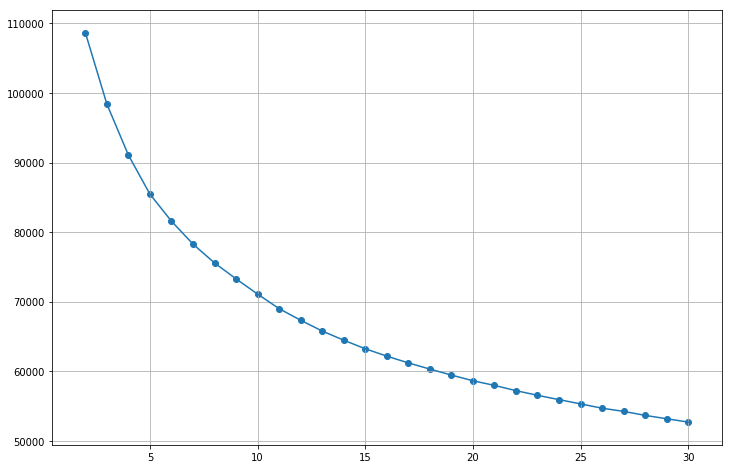

In [11]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(2, 31, 1), inertia)
plt.scatter(range(2, 31, 1), inertia)

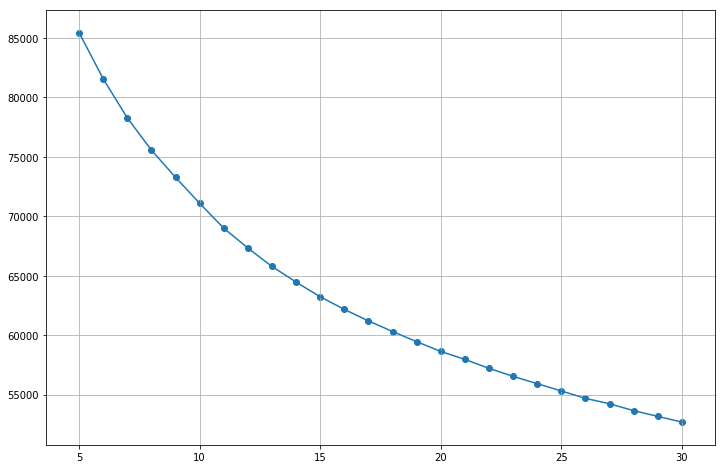

In [12]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(range(5, 31, 1), inertia[3:])
plt.scatter(range(5, 31, 1), inertia[3:])

In [13]:
km = KMeans(n_clusters=9, n_jobs=-1, n_init=50)
km.fit(KMeans_df.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=50, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
pd.Series(km.labels_).value_counts()

4    2442
1    2270
2    1835
7    1695
6    1659
8    1573
3    1450
5    1284
0    1098
dtype: int64

In [15]:
pickle_out = open('../Data/cluster_centers_tfidf_sent_rm_pca_9', 'wb')
pickle.dump(km.cluster_centers_, pickle_out)
pickle_out.close()

In [16]:
KMeans_df = track_features_df.select_dtypes(include=numerics)

In [17]:
df = (track_features_df.merge(
    pd.DataFrame(km.labels_, columns=['labels']),
    left_index=True, right_index=True))

In [18]:
df.to_pickle('../Data/labeled_points_tfidf_sent_rm_pca_9')